In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn, relu
from torchvision import datasets, transforms
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from time import time
from model import LinearVAE, pPCA

In [2]:
class config:
    latent_dim_list = [25,50,100,150,200,250,300]
    data_size = 1000
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(config.device)

def seed_torch(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

cuda:0


In [3]:
seed_torch(0)
data_size = config.data_size
device = config.device
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))
loader = mnist_data.data[:data_size].view(-1, 784) / 255.0
loader_numpy = loader.numpy()
loader = loader.to(device)

latent_dim =50
pcaModel_50 = pPCA(loader_numpy, latent_dim)
W_mle_50, sigma_mle_50, loglikelihood_50 = pcaModel_50.get_result()

exact_result_pPCA=[]
exact_result_pPCA_with_fixed_sigma=[]
VAE_elbo=[]

In [4]:
for latent_dim in config.latent_dim_list:
    start = time()

    # Probability PCA
    pcaModel = pPCA(loader_numpy, latent_dim)
    W_mle, sigma_mle, loglikelihood = pcaModel.get_result()
    exact_result_pPCA.append(loglikelihood)

    # Probability PCA with fixed sigma
    pcaModel_fixed = pPCA(loader_numpy, latent_dim)
    loglikelihood_fixed = pcaModel_fixed.calculate_log_likelihood_with_fixed_sigma(sigma_mle_50)

    exact_result_pPCA_with_fixed_sigma.append(loglikelihood_fixed)
    end = time()
    print(latent_dim, " ", end - start)

25   53.24621224403381
50   39.63261079788208
100   39.24587106704712
150   37.643436431884766
200   38.6313259601593
250   37.02699589729309
300   38.940892696380615


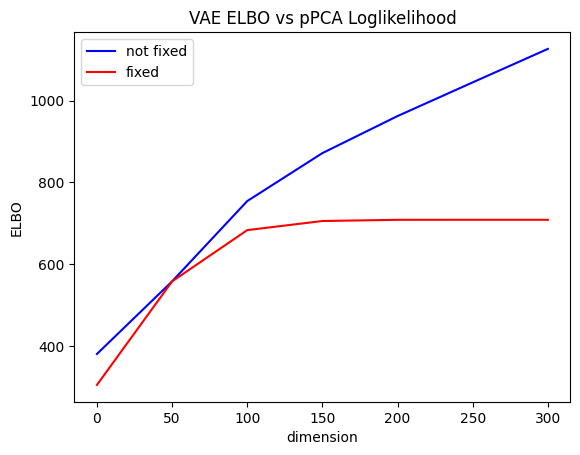

In [5]:
plt.plot(50*np.arange(len(exact_result_pPCA)),exact_result_pPCA,label="not fixed",color='blue')
plt.plot(50*np.arange(len(exact_result_pPCA_with_fixed_sigma)),exact_result_pPCA_with_fixed_sigma,label="fixed",color='red')
plt.xlabel("dimension")
plt.ylabel("ELBO")
plt.legend(loc = "best")
plt.title("VAE ELBO vs pPCA Loglikelihood")
plt.show()

In [ ]:
for idx,latent_dim in enumerate(config.latent_dim_list):
        # Linear VAE
    model = LinearVAE(784, latent_dim, 784, 1.0, True, mode='Analytic').to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    exact_loglikelihood = exact_result_pPCA[idx]
    start = time()
    for i in range(1000000):
        elbo = model(loader)
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        if (np.abs(-elbo.detach().cpu().numpy() - exact_loglikelihood) < 15) and (i >5000):
            print("End Epoch:{}".format(i))
            end = time()
            print("total time:{}s".format(end - start))
            VAE_elbo.append(-elbo.detach().cpu().numpy())
            break          
        if i % 500 == 0:
            print("LatentDim:{},\tEpoch:{},     \t exact loglikelihood:{},   \t ELBO:{}".format(latent_dim,i, exact_loglikelihood, -elbo.item()))
                  
                
                  
                  

LatentDim:25,	Epoch:0,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-1643.026123046875
LatentDim:25,	Epoch:500,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-1066.410888671875
LatentDim:25,	Epoch:1000,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-913.1968994140625
LatentDim:25,	Epoch:1500,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-798.0044555664062
LatentDim:25,	Epoch:2000,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-694.8125
LatentDim:25,	Epoch:2500,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-597.0616455078125
LatentDim:25,	Epoch:3000,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-503.3490295410156
LatentDim:25,	Epoch:3500,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-412.77459716796875
LatentDim:25,	Epoch:4000,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-324.96929931640625
LatentDim:25,	Epoch:4500,     	 exact loglikelihood:380.1850705730385,   	 ELBO:-239.81771850585938
LatentDim:25,	Epoch:

LatentDim:150,	Epoch:4500,     	 exact loglikelihood:871.3963379538686,   	 ELBO:-266.91656494140625
LatentDim:150,	Epoch:5000,     	 exact loglikelihood:871.3963379538686,   	 ELBO:-180.20953369140625
LatentDim:150,	Epoch:5500,     	 exact loglikelihood:871.3963379538686,   	 ELBO:-95.26219177246094
LatentDim:150,	Epoch:6000,     	 exact loglikelihood:871.3963379538686,   	 ELBO:-12.208126068115234
LatentDim:150,	Epoch:6500,     	 exact loglikelihood:871.3963379538686,   	 ELBO:68.85960388183594
LatentDim:150,	Epoch:7000,     	 exact loglikelihood:871.3963379538686,   	 ELBO:147.93765258789062
LatentDim:150,	Epoch:7500,     	 exact loglikelihood:871.3963379538686,   	 ELBO:225.35195922851562
LatentDim:150,	Epoch:8000,     	 exact loglikelihood:871.3963379538686,   	 ELBO:300.3533020019531
LatentDim:150,	Epoch:8500,     	 exact loglikelihood:871.3963379538686,   	 ELBO:371.1736755371094
LatentDim:150,	Epoch:9000,     	 exact loglikelihood:871.3963379538686,   	 ELBO:439.1168518066406
L

LatentDim:300,	Epoch:500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-1096.239990234375
LatentDim:300,	Epoch:1000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-961.2543334960938
LatentDim:300,	Epoch:1500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-846.69140625
LatentDim:300,	Epoch:2000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-740.9854125976562
LatentDim:300,	Epoch:2500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-640.9406127929688
LatentDim:300,	Epoch:3000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-545.1629638671875
LatentDim:300,	Epoch:3500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-452.5869445800781
LatentDim:300,	Epoch:4000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-362.501953125
LatentDim:300,	Epoch:4500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-274.4041442871094
LatentDim:300,	Epoch:5000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:-188.0994110107422


LatentDim:300,	Epoch:41500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1031.4754638671875
LatentDim:300,	Epoch:42000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1032.343994140625
LatentDim:300,	Epoch:42500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1038.06787109375
LatentDim:300,	Epoch:43000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1041.642578125
LatentDim:300,	Epoch:43500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1038.1044921875
LatentDim:300,	Epoch:44000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1044.00537109375
LatentDim:300,	Epoch:44500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1045.3138427734375
LatentDim:300,	Epoch:45000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1046.1458740234375
LatentDim:300,	Epoch:45500,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1046.8604736328125
LatentDim:300,	Epoch:46000,     	 exact loglikelihood:1126.1735191010648,   	 ELBO:1047.562988

In [ ]:
plt.plot(50*np.arange(len(exact_result_pPCA)),exact_result_pPCA,label="pPCA non-fixed sigma",color='blue')
plt.plot(50*np.arange(len(exact_result_pPCA_with_fixed_sigma)),exact_result_pPCA_with_fixed_sigma,label="pPCA fixed sigma",color='red')
plt.plot(50*np.arange(len(VAE_elbo)),VAE_elbo[:],label="VAE ELBO",color='green')

plt.xlabel("Hidden Dimension")
# plt.ylabel("ELBO")
plt.legend(loc = "best")
plt.title("Marginal log-likelihood of pPCA and ELBO")
plt.style.use("seaborn")
plt.savefig("Marginal log-likelihood of pPCA and ELBO",dpi=500)
plt.show()